## Vehicle Detection and Tracking Project



### Step 1: make a list of images to read in

In [2]:
import os
import glob

#images are divided up into vehicles and non-vehicles folders (each of which contains subfolders extras and GTI)
#first locate vehicle images

basedir = 'vehicles/'

#different folders represent different sources for images e.g. GTI, Kitti
image_types = os.listdir(basedir)
cars = []

for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*')) #find pathnames for the given pattern
    
print("Number of vehicle images found is: ", len(cars))
with open("car.txt", "w") as f:
    for fn in cars:
        f.write(fn+'\n')
        
#do the same thing for the non vehicle images
basedir = "non-vehicles/"
image_types = os.listdir(basedir)
notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*')) 
    
print("Number of non-vehicle images found is: ", len(notcars))
with open("notcar.txt", "w") as f:
    for fn in notcars:
        f.write(fn+'\n')


Number of vehicle images found is:  8792
Number of non-vehicle images found is:  8968


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # sklearn <= 0.18: from sklearn.cross_validation import train_test_split



In [22]:
#define a function to return HOG features and visualizations 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    #call with two outputs  if vis == True
    if vis == True:
        features, hog_image = hog(
                                img, orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                transform_sqrt=False,
                                visualise=vis, feature_vector=feature_vec
                                )
        return features, hog_image
    #otherwise call with one output
    else:
        features = hog(
                    img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    transform_sqrt=False,
                    visualise=vis, feature_vector=feature_vec
                    )
        return features
    
#define a function to compute binned color features
#def bin_spatial(img, size=(32,32)):
#use cv2.resize().ravel() to create the feature vector
#features = cv2.resize(img, size).ravel()
#return the feature vector
#return features 

def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel() #ravel return one dimensional array
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


#define a function to compute color histogram features 
def color_hist(img, nbins=32): #bins_range=(0,256)
    #compute the histogram of the color channels seperately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    #concatonate the histogram into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    #Return the individual histograms, bin_centers and feature vector
    return hist_features


# define a function to extract features from a list of images
# have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    #create a list to append feature vectors to
    features = []
    
    #iterate through the list of images
    for file in imgs:
        file_features = []
        #read in each one by one 
        image = mpimg.imread(file)
        #apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat == True:
            #apply color histogram 
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        if hog_feat == True:
            #call the hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True
                                                        )
                                       )
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                               vis=False, feature_vec=True)
            #append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    #return lsit of the feature vectors
    return features


#define a function that takes an image,
#start and stop positions in both x and y,
#window size (x and y dimensions),
#and overlap fraction( for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                xy_window=(64,64), xy_overlap=(0.5, 0.5)):
    #if x and/or y start/stop position not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    #compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    #compute the number of pixel per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    #compute the number of window in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    #initialize a list to append window position to 
    window_list = []
    
    # loop through finding x and y window positions 
    # Note: you could vectorize this step, but in practice 
    # you will be considering windows one by one with your clssifier, so looping makes sence 
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            #calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            #append window position to list
            window_list.append(((startx, starty),(endx, endy)))
            
    #return the list of the window
    return window_list


# define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    #make a copy of the image
    imcopy = np.copy(img)
    
    #iterate through the bounding boxes
    for bbox in bboxes:
        #draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    #return the image copy with boxes drawn
    return imcopy

#define a function to extract features from a single image window
#This function is very similar to extract features()
#just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                       pix_per_cell=8, cell_per_block=2, hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    #1 define an empty list to recieve features
    img_features = []
    
    #2 apply color conversion if other than RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    
    #3 compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    #4 compute histogram features if flag is set  
    if hist_feat == True:
        #apply color histogram 
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    #5 compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True
                                                    )
                                   )
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                           vis=False, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                           vis=False, feature_vec=True)
                
        #append the new feature vector to the features list
        img_features.append(hog_features)
    
    #return concateneted array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
    
#define a function you will pass an image
#and the list of windows to be searched (output of slide windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                  spatial_size=(32,32), hist_bins=32, 
                  hist_range=(0,256), orient=9, 
                  pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):

    #1 create an empty list to receive positive detection windows
    on_windows = []
    
    #2 iterate over all windows in the list
    for window in windows:
        #3 extract the test window from original image
        test_img = cv2.resize(img[ window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4 extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                                      )
        
        #5 scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6 predict using your classifier
        prediction = clf.predict(test_features)
        
        #7 if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #8 return windows for positive directions
    return on_windows




#define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


    
                
                
          

In [13]:
# define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    #make a copy of the image
    imcopy = np.copy(img)
    
    #iterate through the bounding boxes
    for bbox in bboxes:
        #draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    #return the image copy with boxes drawn
    return imcopy

#define a function to extract features from a single image window
#This function is very similar to extract features()
#just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                       pix_per_cell=8, cell_per_block=2, hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    #1 define an empty list to recieve features
    img_features = []
    
    #2 apply color conversion if other than RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    
    #3 compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    #4 compute histogram features if flag is set  
    if hist_feat == True:
        #apply color histogram 
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    #5 compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis, feature_vec=True
                                                    )
                                   )
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                           vis, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                           vis, feature_vec=True)
                
        #append the new feature vector to the features list
        img_features.append(hog_features)
    
    #return concateneted array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


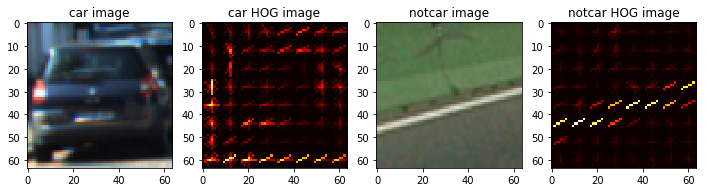

In [16]:
%matplotlib inline

#chose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

#read in car / notcar images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

#define feature parameter
color_space = 'RGB' #can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # can be 0,1,2 or 'ALL'
spatial_size = (16,16) #spatial binning dimensions
hist_bins = 16 #number of histogram bins
spatial_feat = True # Spatial features on or of 
hist_feat = True # Histogram features on or of
hog_feat = True #HOG features on or of

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
                            
                            
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3)) #dpi=80
visualize(fig, 1, 4, images, titles)

In [20]:
#define feature parameter 
#TODO
color_space = 'YCrCb' #can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # can be 0,1,2 or 'ALL'
spatial_size = (16,16) #spatial binning dimensions
hist_bins = 16 #number of histogram bins
spatial_feat = True # Spatial features on or of 
hist_feat = True # Histogram features on or of
hog_feat = True #HOG features on or of

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat)

print(time.time() -t, "Seconds to compute features...")

X = np.vstack((car_features, notcar_features)).astype(np.float64)
#fit a per-column scaler
X_scaler = StandardScaler().fit(X)
#apply the scaler to X
scaled_X = X_scaler.transform(X)

#Define the label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


#split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, ' orientations,', pix_per_cell, ' pixels per cell, ', cell_per_block, ' cells per block, ',
     hist_bins, ' histogram bins, and ', spatial_size, ' spatial sampling')
print('FEature vector legth: ', len(X_train[0]))

#use a linear SVC
svc = LinearSVC()

#check the training time for SVC
t=time.time()

svc.fit(X_train, y_train)

print(round(time.time()-t, 2), " seconds to train svc...")

#check the score of the svc
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


83.104483127594 Seconds to compute features...
Using:  9  orientations, 8  pixels per cell,  2  cells per block,  16  histogram bins, and  (16, 16)  spatial sampling
FEature vector legth:  6108
9.07  seconds to train svc...
Test accuracy of SVC =  0.9887


0.0 1.0


/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.48317790031433105 second to process one image searching 100 windows
0.0 1.0
0.4713411331176758 second to process one image searching 100 windows
0.0 1.0
0.47852516174316406 second to process one image searching 100 windows
0.0 1.0
0.4792318344116211 second to process one image searching 100 windows
0.0 1.0
0.48278093338012695 second to process one image searching 100 windows
0.0 1.0
0.47110891342163086 second to process one image searching 100 windows


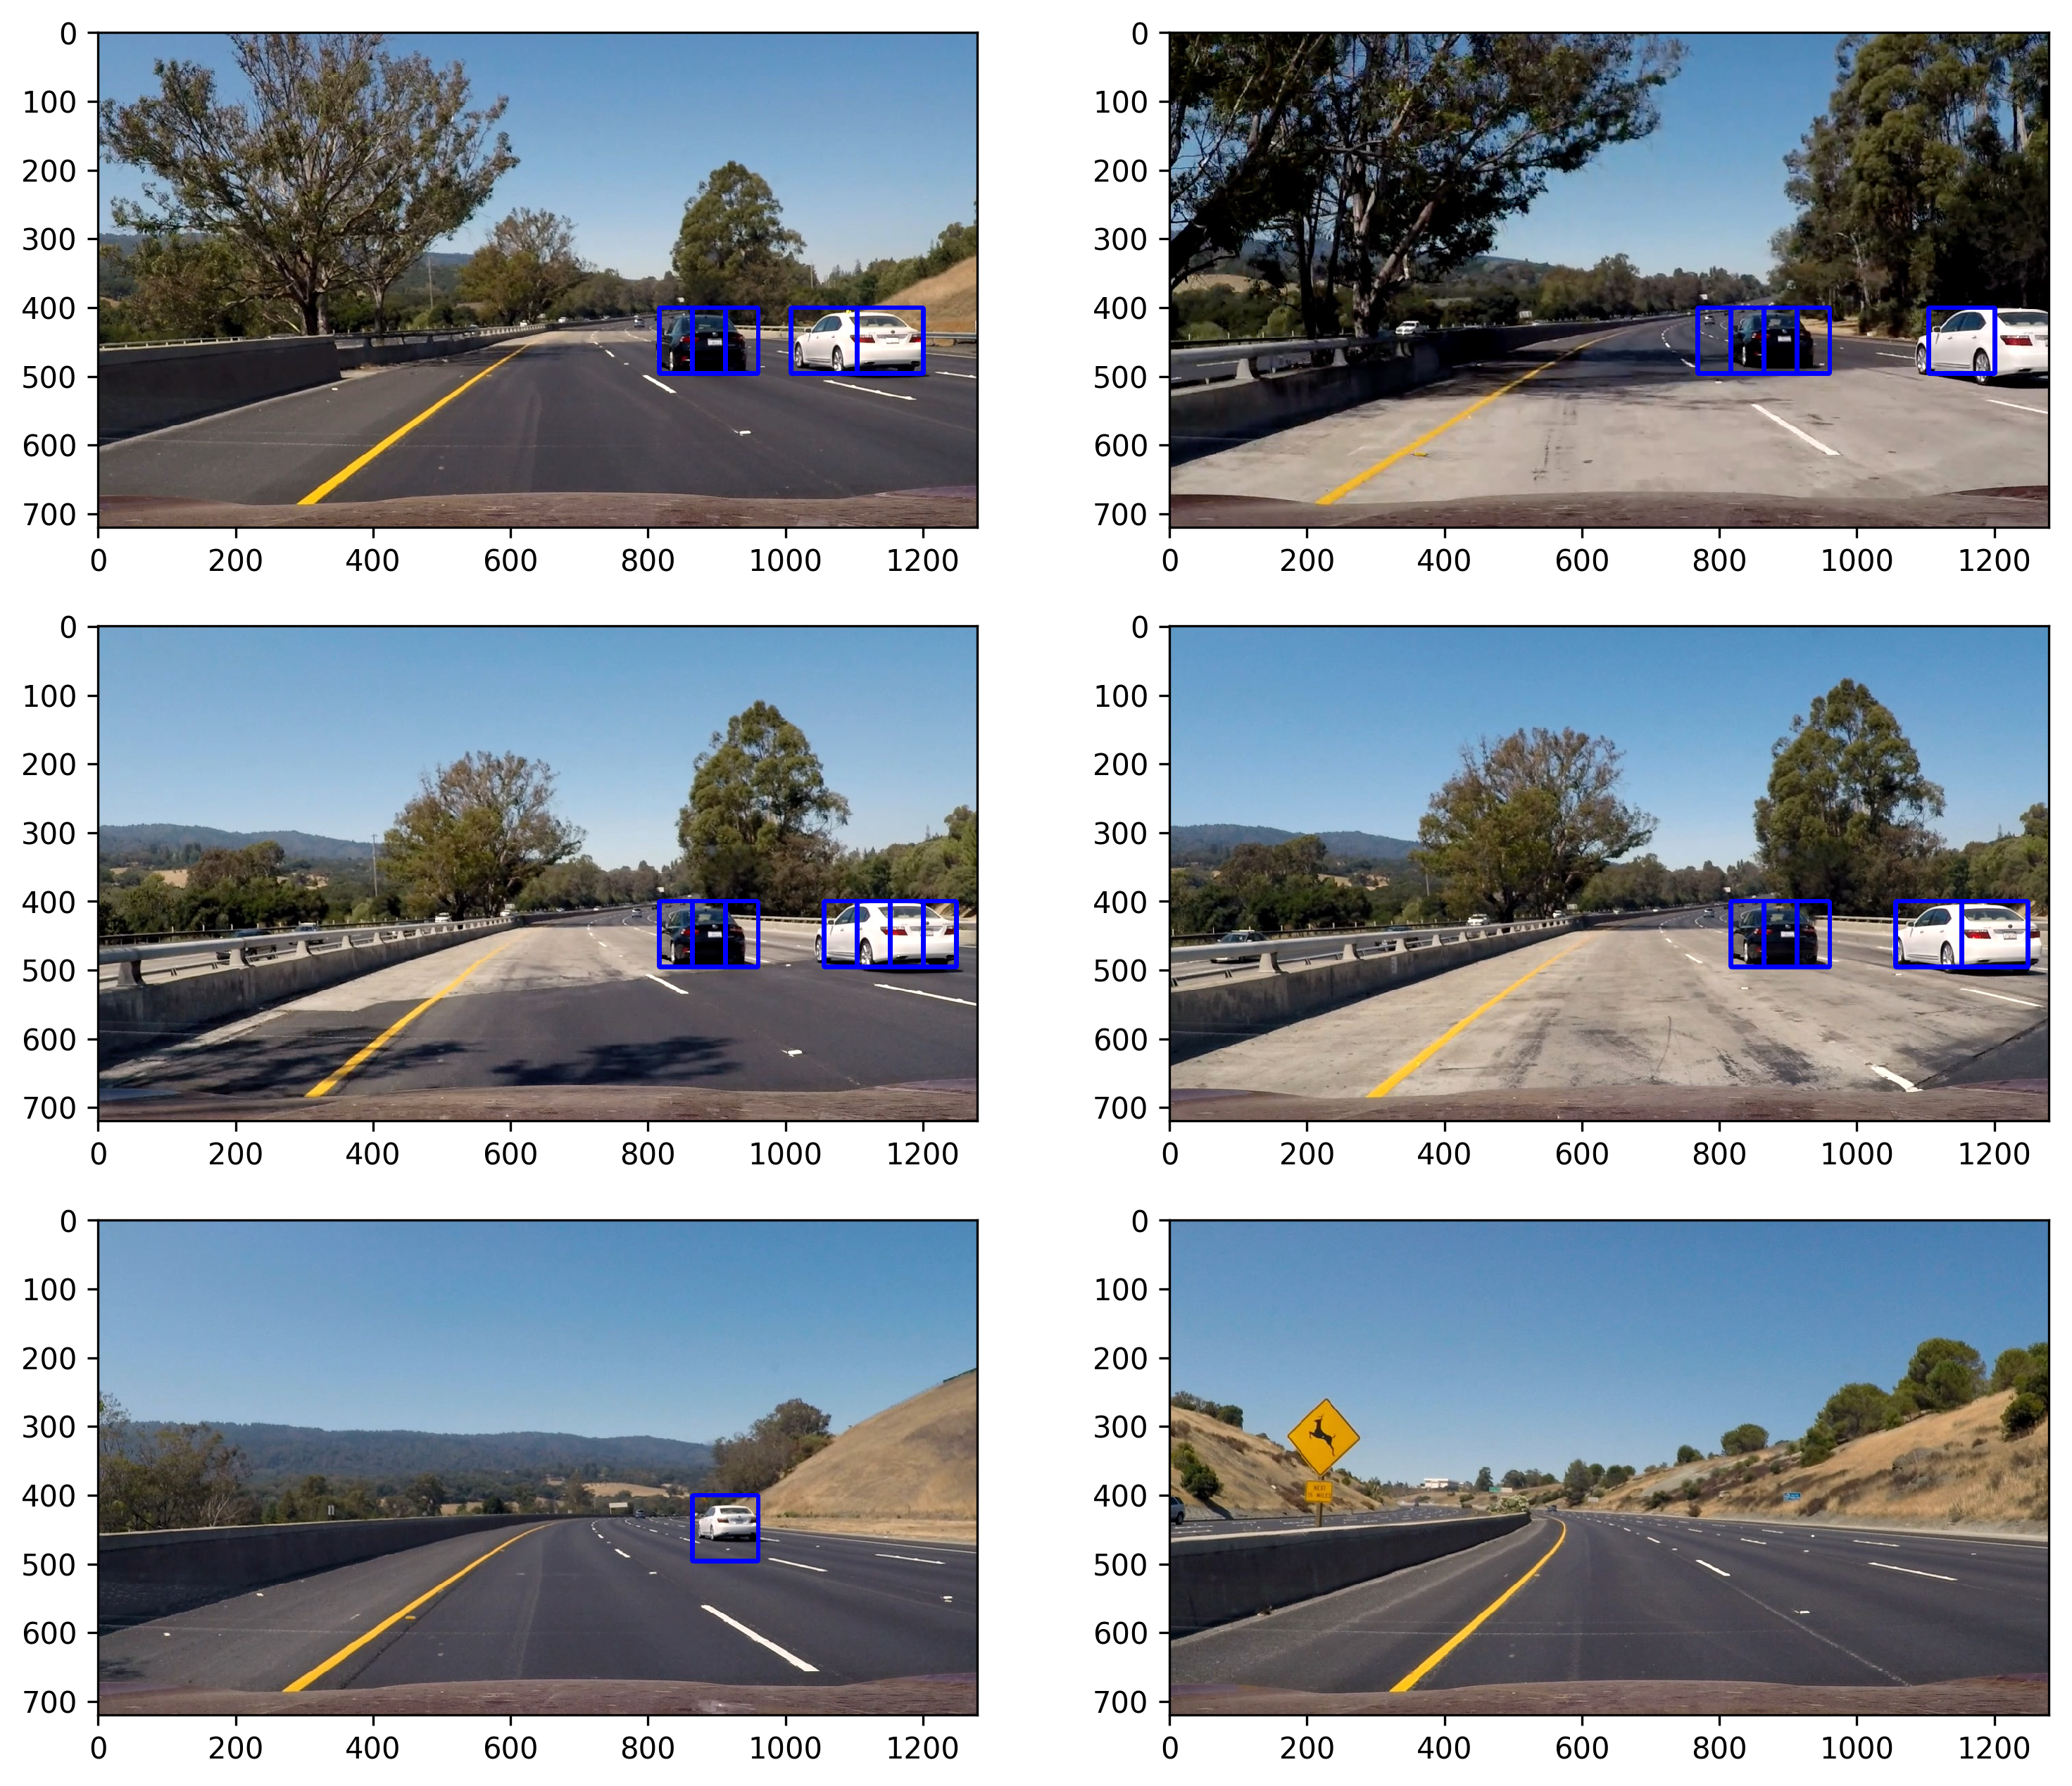

In [26]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

images = []
titles = []


y_start_stop = [400, 656] #Min and max in y to search  in slide_window()
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    #windows
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96,96), xy_overlap=(overlap, overlap))
    
    #windows = winwods1 + windows2
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'second to process one image searching', len(windows), 'windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

In [45]:
import cv2
import numpy as np

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.9975659847259521 seconds to run, total windows =  912
0.9998750686645508 seconds to run, total windows =  912
1.0106909275054932 seconds to run, total windows =  912
1.0118210315704346 seconds to run, total windows =  912
1.0328319072723389 seconds to run, total windows =  912
1.0094730854034424 seconds to run, total windows =  912


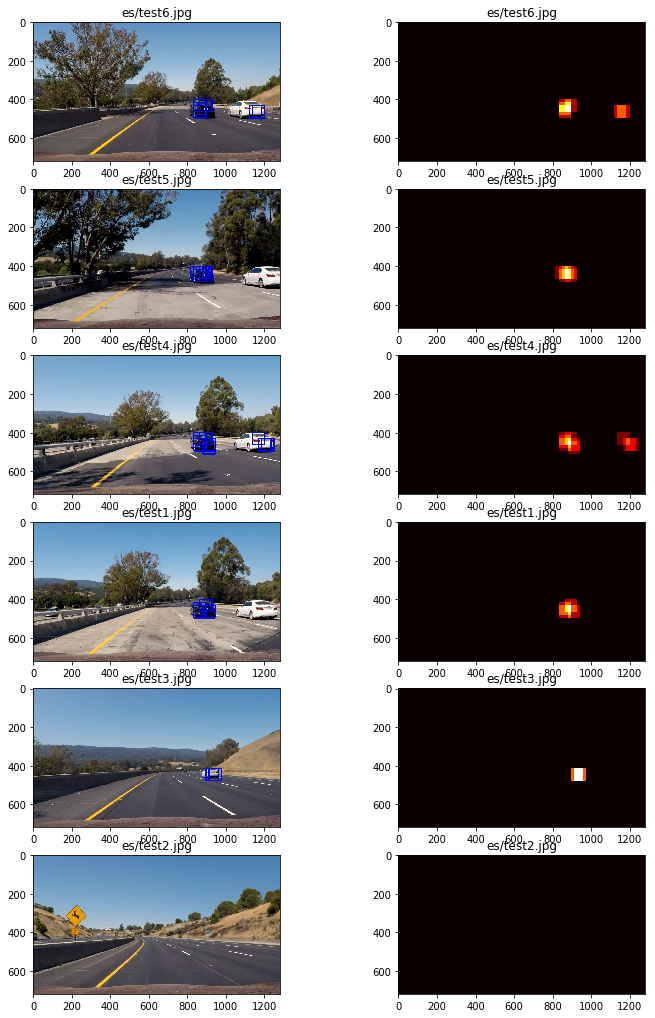

In [49]:
import cv2

out_images = []
out_maps = []
out_titles = []
out_boxes = []

#consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1

#iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    #make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    '''
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[1]/scale)) #TODO
    '''
                                     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
                                     
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = ( window // pix_per_cell) -1
    cells_per_step = 2 #instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire images
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
                                     
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            #extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                                     
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
                                     
            #extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                                     
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                                     
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                                     
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                #TODO
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                                     
    print(time.time()-t, 'seconds to run, total windows = ', count)
                                     
    out_images.append(draw_img)
                                     
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    #heatmap = 255 * heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
                                     
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [57]:
def find_cars(img, scale):
    count = 0
    draw_img = np.copy(img)
    #make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    '''
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[1]/scale)) #TODO
    '''
                                     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
                                     
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = ( window // pix_per_cell) -1
    cells_per_step = 2 #instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire images
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
                                     
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            #extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                                     
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
                                     
            #extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                                     
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                                     
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                                     
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                #TODO
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap 

In [58]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    #zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    #return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    #iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        #Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        #define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                
        #draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
                
    #return the image
    return img

/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


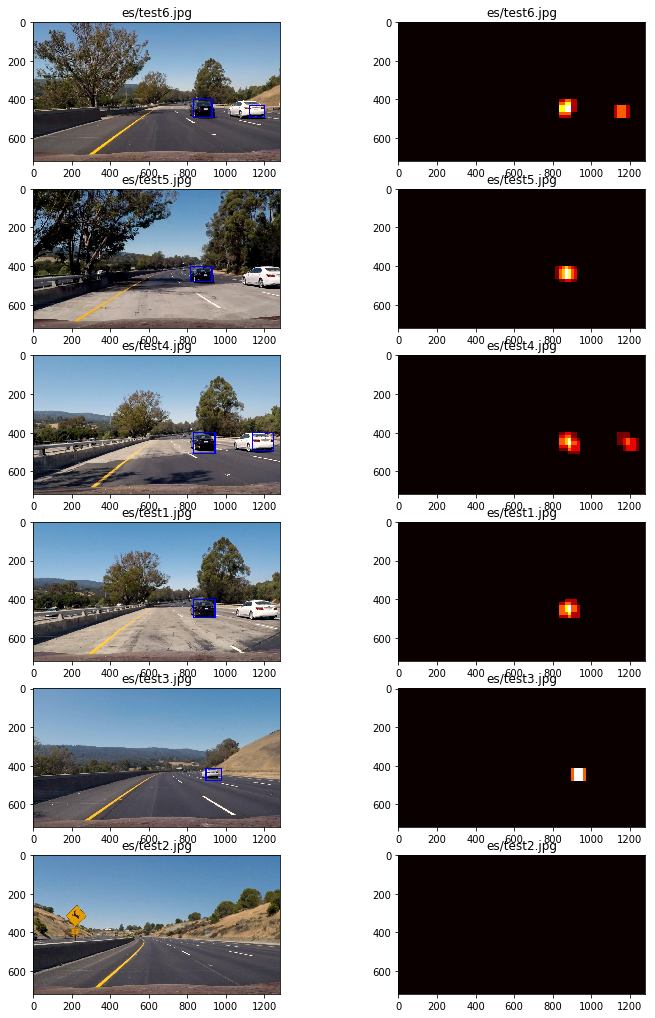

In [61]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1 #TODO: 1.5

#iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    #draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    

    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [63]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    #draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [65]:
#import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
#clip = VideoFileClip('test_video.mp4')
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)

#time
test_clip.write_videofile(test_output, audio=False)

/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]/Users/melihtt/tools/miniconda3/envs/cenv-p36-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|█████████▉| 1260/1261 [21:46<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [66]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))